# 네이버 영화 리뷰 감성 분석 코퍼스(nsmc)를 활용한 토크나이저 성능 비교

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

## 실험목표

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?	
    - 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?	
    - SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?	
    - SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

## 코드 구현

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import konlpy
import re
import sentencepiece as spm
import os
from konlpy.tag import Mecab, Komoran

from sklearn.model_selection import train_test_split

### sp_tokenizer 학습용 데이터 정제

In [2]:
# 데이터 확인
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [3]:
# 중복 제거
raw = list(set(raw))

print("Data Size:", len(raw))

Data Size: 77591


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


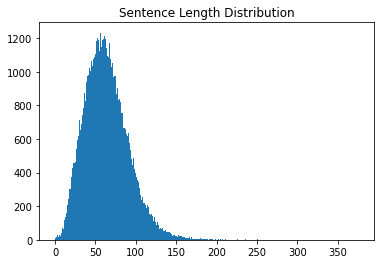

In [4]:
# 데이터 길이 분포 확인
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [5]:
# 이상데이터 확인 
# ex) 길이가 1인 데이터
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


In [6]:
# 길이가 1인 문장 제거
raw = [sen for sen in raw if len(sen) > 1]

print("Data Size:", len(raw))

Data Size: 77590


In [7]:
# 노이즈가 섞인 데이터 존재 확인
check_sentence_with_length(raw, 2)

Q:
4.
3.
6.
..
음식
양파
1.
과일
햇빛
2.
면접


In [8]:
check_sentence_with_length(raw, 10)

결심, 결의, 해답
다칠 위험이 적다.
식별, 판별, 분간
2. 레스토랑 점원
* 여행자의 질병:
1. 장난감 만들기
6. 이벤트 기획자
“아이를 만드세요…
무료 인터넷 사용:
메일 한통이 만드는
햄의 지금 심정은?
웃는 얼굴을 한다:
생후 24개월까지:
tad 조금, 약간
이 건물은 추하다.
이것이 사실일까요?
6살의 아이처럼…”
관여, 참가, 분배
*홍역, 이하선염:
무료 무선 인터넷:
틸트로터, 헬기니?
mortar 박격포
당신 삶을 바꿔라.
모스크바의 밤 풍경
3월’’ ''안경:
환영한다 진행자들！
왜 인간은 이럴까?
요가호텔 숙박비 :
마지막 곤돌라였다.
개야”라고 외쳤다.
그의 저서 ‘행복;
또한 ‘트랜스포머:
왕의 귀환”입니다.
선례가 하나 있다.
스타벅스쿠폰 무료!
5.어미니의 실수:
한국정보통신산업협회
당연시 될 것이다.
hostage 인질
selloff 주가
적대, 대립, 항쟁
돈과 모든 것을…”
위태로운 일자리 수
전체가 아닙니다.”
투기(매매), 추론
(시위자들의 외침)
오차범위는 없었다.
epic 서사시적인
숙박비 카드 결재:
휘드비섬, 워싱턴주
월가의 종가입니다.
-순간순간을 즐기기
그는 "올슨은 매우
대학탐방은 이렇다.
그래서 다시 쐈다.
고프섬은 무인도다.
고맙습니다, 리타.
* 등을 두드려라.
비난, 고소, 고발
日, 경기침체 심화
“ 폴 하비입니다.
운에 맡기고 해보다
존 벨몬트였습니다.
친절하게 대화한다.
▶관련 동영상 보기
친숙하게 들리나요?
5. 운동 트레이너
그의 근육질 어깨.
헌신, 봉헌, 헌정
숙청이 시작되었다.
여러분은 이 동물이
-반으로 줄인 무게


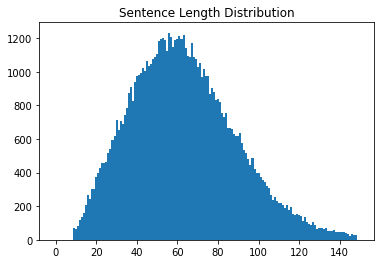

In [9]:
# 연산 효율화와 노이즈 최소화를 위해 10~150 길이의 데이터만 추출
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in raw if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### SentencePiece를 이용해 토크나이저 학습

In [10]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000
model_name = 'korean_spm'

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix={} --vocab_size={}'.format(temp_file,model_name, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l

# korean_spm.model (sp_tokenizer 모델 생성)
# korean_spm.vocab (단어 사전 생성)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

total 1124
drwxr-xr-x 2 root root   4096 Feb 25 03:37 data
-rw-r--r-- 1 root root 376816 Feb 25 07:36 korean_spm.model
-rw-r--r-- 1 root root 146213 Feb 25 07:36 korean_spm.vocab
drwxr-xr-x 5 root root   4096 Feb 25 02:45 nsmc
-rw-r--r-- 1 root root 376209 Feb 25 06:54 nsmc_korean_spm.model
-rw-r--r-- 1 root root 145641 Feb 25 06:54 nsmc_korean_spm.vocab
-rw-r--r-- 1 root root  91657 Feb 25 07:32 nsmc_tokenizer.ipynb


In [11]:
# 생성된 토크나이저 동작 확인
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### nsmc 데이터를 활용한 성능비교

1. sp_tokenize를 nsmc 데이터로 학습 후 성능 비교
2. 토크나이저 비교
    - SentencePiece, mecab, KOMORAN 비교
    - 텍스트 정제 수준을 다르게 비교
        - 한글, 영어, , . ! ? 남겨두고 텍스트 정제
        - 한글, 영어만 남김('ㅋㅋㅋ' 같은 모음이나 자음이 분리된 경우도 제거)
3. sp_tokenize를 vocab_size를 4000, 16000으로 변경해서 성능비교

In [12]:
# nsmc 데이터 불러오기
nsmc_train = os.getenv('HOME')+'/aiffel/sp_tokenizer/nsmc/ratings_train.txt'
nsmc_test = os.getenv('HOME')+'/aiffel/sp_tokenizer/nsmc/ratings_test.txt'

train_df = pd.read_csv(nsmc_train, sep='\t')
test_df = pd.read_csv(nsmc_test, sep='\t')

In [13]:
len(train_df), len(test_df)

(150000, 50000)

In [14]:
# 결측치 확인 및 제거
train_df.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [15]:
test_df.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [16]:
train_df = train_df.dropna(subset=['document'])
test_df = test_df.dropna(subset=['document'])

print(train_df.isnull().sum())
print(test_df.isnull().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


In [17]:
# 중복데이터 확인 및 제거
print(train_df.duplicated(subset=['document']).sum())
print(test_df.duplicated(subset=['document']).sum())

3813
840


In [18]:
train_df = train_df.drop_duplicates(subset=['document'])
test_df = test_df.drop_duplicates(subset=['document'])

print(train_df.duplicated(subset=['document']).sum())
print(test_df.duplicated(subset=['document']).sum())

0
0


In [19]:
len(train_df), len(test_df)

(146182, 49157)

### 실험1. sp_tokenize를 nsmc 데이터로 학습 후 성능 비교

In [20]:
# 텍스트 정제
# 토크나이저 성능 비교를 위해 최소한의 정제(특수문자만 제거)

def clean_text_ver1(text):
    # 정규 표현식을 사용하여 원하는 특수문자 제외하고 제거 (한글, 영어, 숫자, 공백, ,.!? 유지)
    text = re.sub(r"[^가-힣a-zA-Z0-9\s,.!?]", "", text)
    
    # 연속된 공백을 하나의 공백으로 변환
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

In [21]:
# NSMC 데이터 정제
train_df['cleaned_document'] = train_df['document'].astype(str).apply(clean_text_ver1)
test_df['cleaned_document'] = test_df['document'].astype(str).apply(clean_text_ver1)

train_df.head()

,id,document,label,cleaned_document
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙.. 진짜 짜증나네요 목소리
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2,10265843,너무재밓었다그래서보는것을추천한다,0,너무재밓었다그래서보는것을추천한다
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...


In [22]:
# sp-토크나이저 함수 선언
def sp_tokenize(s, corpus, vocab_name, max_len): 
    vocab_dir = f"./{vocab_name}.vocab" 
    print(max_len)
    print(vocab_dir)
        
    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open(vocab_dir, 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=max_len)

    return tensor, word_index, index_word

In [74]:
sp = spm.SentencePieceProcessor()
sp.load("korean_spm.model")
model_name = 'korean_spm'
max_len  = int(np.percentile([len(sp.EncodeAsIds(text)) for text in train_df['cleaned_document']], 95))  # 상위 5% 제거

# 토큰화 적용
X_train, word_index, index_word = sp_tokenize(sp, train_df['cleaned_document'].tolist(), model_name, max_len)
X_test, _, _ = sp_tokenize(sp, test_df['cleaned_document'].tolist(), model_name, max_len)

68
./korean_spm.vocab
68
./korean_spm.vocab


In [75]:
print(max_len)

68


In [76]:
y_train = train_df['label'].values
y_test = test_df['label'].values

In [77]:
print("X_train 크기:", X_train.shape)
print("X_train 샘플 데이터:", X_train[0])
print("y_train 크기:", y_train.shape)
print("y_train 샘플 값:", y_train[:10])


X_train 크기: (146182, 68)
X_train 샘플 데이터: [ 141  106 2611    3    3  912 4856    4 4856  752   69  554  514 2648
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
y_train 크기: (146182,)
y_train 샘플 값: [0 1 0 0 1 0 0 0 1 1]


In [78]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("훈련 데이터 크기:", X_train.shape)
print("검증 데이터 크기:", X_val.shape)
print("테스트 데이터 크기:", X_test.shape)

훈련 데이터 크기: (116945, 68)
검증 데이터 크기: (29237, 68)
테스트 데이터 크기: (49157, 68)


In [79]:
# 모델 하이퍼파라미터 설정
embedding_dim = 128
lstm_units = 64
max_length = X_train.shape[1]  # 패딩 후 문장 최대 길이

# LSTM 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length), # vocab_size = 8000
    tf.keras.layers.LSTM(lstm_units, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val)
)

Epoch 1/5
1828/1828 [==============================] - 14s 7ms/step - loss: 0.6712 - accuracy: 0.5844 - val_loss: 0.6704 - val_accuracy: 0.6049
Epoch 2/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.6487 - accuracy: 0.6159 - val_loss: 0.5738 - val_accuracy: 0.6920
Epoch 3/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.4490 - accuracy: 0.7936 - val_loss: 0.4181 - val_accuracy: 0.8110
Epoch 4/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.3779 - accuracy: 0.8358 - val_loss: 0.3781 - val_accuracy: 0.8302
Epoch 5/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.3430 - accuracy: 0.8512 - val_loss: 0.3748 - val_accuracy: 0.8354


#### sp_tokenizer 기존(korean-english-park)버전 정확도 :   0.8327

In [80]:
# 테스트 데이터 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print("테스트 정확도:", test_acc)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3784 - accuracy: 0.8328
테스트 정확도: 0.832780659198761


In [81]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/nsmc_clean_train.txt'

vocab_size = 8000
model_name = "nsmc_korean_spm"

with open(temp_file, 'w') as f:
    for row in train_df['cleaned_document']:   # 정제된 텍스트
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix={} --vocab_size={}'.format(temp_file, model_name, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/nsmc_clean_train.txt --model_prefix=nsmc_korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/nsmc_clean_train.txt
  input_format: 
  model_prefix: nsmc_korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1


total 1104
drwxr-xr-x 2 root root   4096 Feb 25 03:37 data
-rw-r--r-- 1 root root 376816 Feb 25 06:32 korean_spm.model
-rw-r--r-- 1 root root 146213 Feb 25 06:32 korean_spm.vocab
drwxr-xr-x 5 root root   4096 Feb 25 02:45 nsmc
-rw-r--r-- 1 root root 376209 Feb 25 06:54 nsmc_korean_spm.model
-rw-r--r-- 1 root root 145641 Feb 25 06:54 nsmc_korean_spm.vocab
-rw-r--r-- 1 root root  73243 Feb 25 06:53 nsmc_tokenizer.ipynb


In [82]:
sp = spm.SentencePieceProcessor()
sp.load("nsmc_korean_spm.model")
model_name = 'nsmc_korean_spm'
max_len  = int(np.percentile([len(sp.EncodeAsIds(text)) for text in train_df['cleaned_document']], 95))  # 상위 5% 제거

# 토큰화 적용
X_train, word_index, index_word = sp_tokenize(sp, train_df['cleaned_document'].tolist(), model_name, max_len)
X_test, _, _ = sp_tokenize(sp, test_df['cleaned_document'].tolist(), model_name, max_len)

y_train = train_df['label'].values
y_test = test_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 모델 하이퍼파라미터 설정
embedding_dim = 128
lstm_units = 64
max_length = X_train.shape[1]  # 패딩 후 문장 최대 길이

# LSTM 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length), # vocab_size = 8000
    tf.keras.layers.LSTM(lstm_units, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val)
)

51
./nsmc_korean_spm.vocab
51
./nsmc_korean_spm.vocab
Epoch 1/5
1828/1828 [==============================] - 13s 6ms/step - loss: 0.6632 - accuracy: 0.5894 - val_loss: 0.6713 - val_accuracy: 0.5541
Epoch 2/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.6617 - accuracy: 0.5765 - val_loss: 0.6493 - val_accuracy: 0.5958
Epoch 3/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.4907 - accuracy: 0.7457 - val_loss: 0.3610 - val_accuracy: 0.8426
Epoch 4/5
1828/1828 [==============================] - 10s 6ms/step - loss: 0.3197 - accuracy: 0.8654 - val_loss: 0.3406 - val_accuracy: 0.8532
Epoch 5/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.2759 - accuracy: 0.8856 - val_loss: 0.3458 - val_accuracy: 0.8515


#### sp_tokenizer nsmc버전 정확도 :  0.8369

In [62]:
# 테스트 데이터 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print("테스트 정확도:", test_acc)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.6319 - accuracy: 0.8369
테스트 정확도: 0.8369103074073792


#### 결론
- 1차 학습 결과 korean-english-park데이터로 학습시킨 토크나이저와  nsmc로 학습시킨 토크나이저에 성능차이가 없음(0.497로 동일).
- 정상적인 학습이 진행이 안되는걸 확인(val_loss, val_acc 가 동일)
- 왜 학습이 안될까? 대해서 모델 설계부터 데이터 토큰화까지 확인
   - 토큰화 비교 결과 두 토크나이저 결과가 다름.-> 그런데 왜 성능이 똑같을까? 이상함.
     -> 확인결과 학습이 정상적으로 진행되지않고 있음 -> Dropout 낮게 조절, learning_rate 조절 등 여러 시도
     -> but, 안됨 ㅠ -> 원인. max_length가 너무 길어서 학습속도 저하 -> 정상적인 학습이 되지않음 -> max_length 지정(기존 140 -> 107)
     -> max_length 바꾸니 학습됨 -> 또 문제, nsmc로 토크나이저 하면 학습이 안됨. 왜그럴까? 아직 ing
- 문제이유 알아냄
    - 토큰이 아닌 문자기준으로 max_len을 측정해서 토큰나이저가 바뀌니깐 학습이 정상적으로 되지않았더거임
    - 즉, 107이랑 길이가 korean-english-park 토크나이저면 학습이 될 정도였지만 nsmc 토크나이저한테 너무 커서 정상적인 연산이 되지않음
    - 토큰기준으로 문장 길이를 측정하도록 코드 수정, 기존 토크나이저는 68, nsmc는 51
- 최종 학습 결과 
    - korean-english-park 토크나이저 : 0.8327
    - nsmc 토크나이저 : 0.8369
    - 큰 차이가 없다. 즉, korean-english-park 토크나이저가 충분히 다양한 한국어 데이터를 학습했거나 혹은 SentencePiece 특성상 내부단어를 분리하기때문에 토큰에 큰 성능향상은 없다 

In [41]:
# SentencePiece 모델 로드
sp_korean = spm.SentencePieceProcessor()
sp_korean.load("korean_spm.model")  # 기존 모델

sp_nsmc = spm.SentencePieceProcessor()
sp_nsmc.load("nsmc_korean_spm.model")  # NSMC 학습 모델

# 비교할 문장 샘플 (train_df에서 5개 선택)
sample_texts = train_df['cleaned_document'].sample(5, random_state=42).tolist()

# 토큰화 비교 함수
def compare_tokenization(texts, sp1, sp2, model_name1="korean_spm", model_name2="nsmc_korean_spm"):
    results = []
    for text in texts:
        tokens1 = sp1.EncodeAsPieces(text)
        tokens2 = sp2.EncodeAsPieces(text)
        print(tokens1)
        print(tokens2)

        results.append({
            "Original Text": text,
            f"{model_name1} Tokens": " ".join(tokens1),
            f"{model_name2} Tokens": " ".join(tokens2),
        })
    
    return pd.DataFrame(results)

# 비교 실행
comparison_df = compare_tokenization(sample_texts, sp_korean, sp_nsmc)
comparison_df

['▁재', '밌', '네', '요']
['▁재밌네요']
['▁사랑', '과', '▁영', '혼', '사', '랑', '과', '▁영', '혼', '사', '랑', '과', '▁영', '혼']
['▁사랑과', '▁영혼', '사랑', '과', '▁영혼', '사랑', '과', '▁영혼']
['▁여성', '의', '▁입장', '에서', '▁바라', '보', '는', '▁잔', '잔', '하면서', '도', '▁기분', '이', '▁', '묘', '해', '지는', '▁느낌']
['▁여성', '의', '▁입장에서', '▁바라', '보는', '▁잔잔하면서', '도', '▁기분이', '▁', '묘', '해지는', '▁느낌']
['▁진정', '한', '▁사랑', '을', '▁알아', '가', '는', '▁성장', '영화', '.', '▁다', '소', '▁충격', '적', '이나', '▁두', '▁배우', '의', '▁진', '지', '한', '▁연기', '가', '▁인상', '적', '.']
['▁진정한', '▁사랑을', '▁알아', '가', '는', '▁성장', '영화', '.', '▁다소', '▁충격적', '이나', '▁두', '▁배우의', '▁진지한', '▁연기가', '▁인상적', '.']
['▁여자', '주', '인', '공', '▁너무', '▁', '멋', '있다']
['▁여자주인공', '▁너무', '▁멋있다']


,Original Text,korean_spm Tokens,nsmc_korean_spm Tokens
0,재밌네요,▁재 밌 네 요,▁재밌네요
1,사랑과 영혼사랑과 영혼사랑과 영혼,▁사랑 과 ▁영 혼 사 랑 과 ▁영 혼 사 랑 과 ▁영 혼,▁사랑과 ▁영혼 사랑 과 ▁영혼 사랑 과 ▁영혼
2,여성의 입장에서 바라보는 잔잔하면서도 기분이 묘해지는 느낌,▁여성 의 ▁입장 에서 ▁바라 보 는 ▁잔 잔 하면서 도 ▁기분 이 ▁ 묘 해 지는...,▁여성 의 ▁입장에서 ▁바라 보는 ▁잔잔하면서 도 ▁기분이 ▁ 묘 해지는 ▁느낌
3,진정한 사랑을 알아가는 성장영화. 다소 충격적이나 두 배우의 진지한 연기가 인상적.,▁진정 한 ▁사랑 을 ▁알아 가 는 ▁성장 영화 . ▁다 소 ▁충격 적 이나 ▁두 ...,▁진정한 ▁사랑을 ▁알아 가 는 ▁성장 영화 . ▁다소 ▁충격적 이나 ▁두 ▁배우의...
4,여자주인공 너무 멋있다,▁여자 주 인 공 ▁너무 ▁ 멋 있다,▁여자주인공 ▁너무 ▁멋있다


In [44]:
print("Korean-English-Park vocab 크기:", sp_korean.GetPieceSize())
print("NSMC vocab 크기:", sp_nsmc.GetPieceSize())


Korean-English-Park vocab 크기: 8000
NSMC vocab 크기: 8000


In [46]:
sample_text = "이 영화 정말 재미있어요!"

tokens_park = sp_korean.EncodeAsPieces(sample_text)
tokens_nsmc = sp_nsmc.EncodeAsPieces(sample_text)

print("Korean-English-Park 토큰화:", tokens_park)
print("NSMC 토큰화:", tokens_nsmc)


Korean-English-Park 토큰화: ['▁이', '▁영화', '▁정말', '▁재미있', '어', '요', '!']
NSMC 토큰화: ['▁이', '▁영화', '▁정말', '▁재미있어요', '!']


### 실험 2. 토크나이저 비교
    - SentencePiece, mecab, KOMORAN 비교
    - 텍스트 정제 수준을 다르게 비교
        - 한글, 영어, , . ! ? 남겨두고 텍스트 정제
        - 한글, 영어만 남김('ㅋㅋㅋ' 같은 모음이나 자음이 분리된 경우도 제거)

In [23]:
mecab = Mecab()
komoran = Komoran()
sp = spm.SentencePieceProcessor()
sp.load("nsmc_korean_spm.model")
model_name = "nsmc_korean_spm"

In [24]:
def tokenize_mecab(text):
    return mecab.morphs(text)

def tokenize_komoran(text):
    return komoran.morphs(text)

In [35]:
corpus = train_df['cleaned_document'].tolist()  # 정제된 문장 데이터

# ======= 1️⃣ SentencePiece `max_len` 계산 =======
max_len_sp = int(np.percentile([len(sp.EncodeAsIds(text)) for text in corpus], 95))
print(f"SentencePiece max_len: {max_len_sp}")

# ======= 2️⃣ Mecab `max_len` 계산 =======
max_len_mecab = int(np.percentile([len(mecab.morphs(text)) for text in corpus], 95))
print(f"Mecab max_len: {max_len_mecab}")

# ======= 3️⃣ KOMORAN `max_len` 계산 =======
max_len_komoran = int(np.percentile([len(komoran.morphs(text)) for text in corpus], 95))
print(f"KOMORAN max_len: {max_len_komoran}")

SentencePiece max_len: 51
Mecab max_len: 55
KOMORAN max_len: 58


In [33]:
max_len_sp = 51
max_len_mecab = 55
max_len_komoran = 58

In [34]:
print("🔹 SentencePiece 토큰화 중...")
X_train_sp, _, _ = sp_tokenize(sp, train_df['cleaned_document'].tolist(),model_name, max_len_sp)
X_test_sp, _, _ = sp_tokenize(sp, test_df['cleaned_document'].tolist(),model_name, max_len_sp)

🔹 SentencePiece 토큰화 중...
51
./nsmc_korean_spm.vocab
51
./nsmc_korean_spm.vocab


In [29]:

from collections import Counter
print("🔹 KOMORAN 토큰화 중...")
# 🔹 Komoran 단어 사전 생성
word_freq_komoran = Counter(word for sentence in X_train_komoran for word in sentence)
word_index_komoran = {word: i+1 for i, (word, _) in enumerate(word_freq_komoran.most_common())}

# 🔹 정수 인코딩 적용 (딕셔너리 `get()` 사용하여 빠르게 변환)
X_train_komoran_int = [[word_index_komoran.get(word, 0) for word in sentence] for sentence in X_train_komoran]
X_test_komoran_int = [[word_index_komoran.get(word, 0) for word in sentence] for sentence in X_test_komoran]

# 🔹 문장 길이 맞추기 (패딩 적용)
max_len_komoran = int(np.percentile([len(seq) for seq in X_train_komoran_int], 95))  # 상위 95% 길이
X_train_komoran_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_komoran_int, padding='post', maxlen=max_len_komoran)
X_test_komoran_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_komoran_int, padding='post', maxlen=max_len_komoran)

print("완료")

🔹 KOMORAN 토큰화 중...
완료


In [30]:
print("🔹 Mecab 토큰화 중...")
# 🔹 Mecab 단어 사전 구축
word_freq_mecab = Counter(word for sentence in X_train_mecab for word in sentence)
word_index_mecab = {word: i+1 for i, (word, _) in enumerate(word_freq_mecab.most_common())}

# 🔹 정수 인코딩 적용
X_train_mecab_int = [[word_index_mecab.get(word, 0) for word in sentence] for sentence in X_train_mecab]
X_test_mecab_int = [[word_index_mecab.get(word, 0) for word in sentence] for sentence in X_test_mecab]

# 🔹 문장 길이 맞추기 (패딩 적용)
max_len_mecab = int(np.percentile([len(seq) for seq in X_train_mecab_int], 95))  # 상위 95% 길이
X_train_mecab_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_mecab_int, padding='post', maxlen=max_len_mecab)
X_test_mecab_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_mecab_int, padding='post', maxlen=max_len_mecab)

print("완료")

🔹 Mecab 토큰화 중...
완료


In [35]:
# 라벨 설정
y_train = train_df['label'].values
y_test = test_df['label'].values

In [36]:
X_train_sp, X_val_sp, y_train_sp, y_val_sp = train_test_split(X_train_sp, y_train, test_size=0.2, random_state=42)
X_train_mecab, X_val_mecab, y_train_mecab, y_val_mecab = train_test_split(X_train_mecab_pad, y_train, test_size=0.2, random_state=42)
X_train_komoran, X_val_komoran, y_train_komoran, y_val_komoran = train_test_split(X_train_komoran_pad, y_train, test_size=0.2, random_state=42)

In [37]:
# 모델학습 함수
def training_model(X_train, X_val, y_tain, y_val):
    # 모델 하이퍼파라미터 설정
    embedding_dim = 128
    lstm_units = 64
    max_length = X_train.shape[1]  # 패딩 후 문장 최대 길이

    # LSTM 모델 구성
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length), # vocab_size = 8000
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    learning_rate = 0.001  
    optimizer = Adam(learning_rate=learning_rate)

    # 모델 컴파일
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_data=(X_val, y_val)
    )
    
    return model

In [ ]:
model_sp = training_model(X_train_sp, X_val_sp, y_train_sp, y_val_sp)

In [ ]:
model_mecab = training_model(X_train_mecab, X_val_mecab, y_train_mecab, y_val_mecab)

In [ ]:
model_komoran = training_model(X_train_komoran, X_val_komoran, y_train_komoran, y_val_komoran)

In [ ]:
sp_test_loss, sp_test_acc = model_sp.evaluate(X_test, y_test)
print("테스트 정확도:", sp_test_acc)

In [ ]:
mecab_test_loss, mecab_test_acc = model_mecab.evaluate(X_test, y_test)
print("테스트 정확도:", mecab_test_acc)

In [ ]:
komoran_test_loss, komoran_test_acc = model_komoran.evaluate(X_test, y_test)
print("테스트 정확도:", komoran_test_acc)

### 실험 3. vocab_size 바꿔보며 테스트

In [39]:
# vocab_size = 4000
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/nsmc_clean_train.txt'

vocab_size = 4000
model_name = "nsmc_korean_spm_4000"

with open(temp_file, 'w') as f:
    for row in train_df['cleaned_document']:   # 정제된 텍스트
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix={} --vocab_size={}'.format(temp_file, model_name, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/nsmc_clean_train.txt --model_prefix=nsmc_korean_spm_4000 --vocab_size=4000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/nsmc_clean_train.txt
  input_format: 
  model_prefix: nsmc_korean_spm_4000
  model_type: UNIGRAM
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  

total 1492
drwxr-xr-x 2 root root   4096 Feb 25 03:37 data
-rw-r--r-- 1 root root 376816 Feb 25 07:36 korean_spm.model
-rw-r--r-- 1 root root 146213 Feb 25 07:36 korean_spm.vocab
drwxr-xr-x 5 root root   4096 Feb 25 02:45 nsmc
-rw-r--r-- 1 root root 299624 Feb 25 07:45 nsmc_korean_spm_4000.model
-rw-r--r-- 1 root root  65503 Feb 25 07:45 nsmc_korean_spm_4000.vocab
-rw-r--r-- 1 root root 376209 Feb 25 06:54 nsmc_korean_spm.model
-rw-r--r-- 1 root root 145641 Feb 25 06:54 nsmc_korean_spm.vocab
-rw-r--r-- 1 root root  99505 Feb 25 07:45 nsmc_tokenizer.ipynb


In [40]:
sp = spm.SentencePieceProcessor()
sp.load("nsmc_korean_spm_4000.model")
model_name = 'nsmc_korean_spm_4000'
max_len  = int(np.percentile([len(sp.EncodeAsIds(text)) for text in train_df['cleaned_document']], 95))  # 상위 5% 제거

# 토큰화 적용
X_train, word_index, index_word = sp_tokenize(sp, train_df['cleaned_document'].tolist(), model_name, max_len)
X_test, _, _ = sp_tokenize(sp, test_df['cleaned_document'].tolist(), model_name, max_len)

y_train = train_df['label'].values
y_test = test_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 모델 하이퍼파라미터 설정
embedding_dim = 128
lstm_units = 64
max_length = X_train.shape[1]  # 패딩 후 문장 최대 길이

# LSTM 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length), # vocab_size = 4000
    tf.keras.layers.LSTM(lstm_units, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val)
)

59
./nsmc_korean_spm_4000.vocab
59
./nsmc_korean_spm_4000.vocab
Epoch 1/5
1828/1828 [==============================] - 21s 7ms/step - loss: 0.6568 - accuracy: 0.6021 - val_loss: 0.6425 - val_accuracy: 0.6201
Epoch 2/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.6637 - accuracy: 0.5753 - val_loss: 0.6883 - val_accuracy: 0.5138
Epoch 3/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.6748 - accuracy: 0.5468 - val_loss: 0.6532 - val_accuracy: 0.7056
Epoch 4/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.5738 - accuracy: 0.7351 - val_loss: 0.5577 - val_accuracy: 0.7508
Epoch 5/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.5041 - accuracy: 0.7752 - val_loss: 0.5283 - val_accuracy: 0.7438


In [41]:
# 테스트 데이터 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print("테스트 정확도:", test_acc)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.5337 - accuracy: 0.7395
테스트 정확도: 0.7395080924034119


In [42]:
# vocab_size = 16000
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/nsmc_clean_train.txt'

vocab_size = 16000
model_name = "nsmc_korean_spm_16000"

with open(temp_file, 'w') as f:
    for row in train_df['cleaned_document']:   # 정제된 텍스트
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix={} --vocab_size={}'.format(temp_file, model_name, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/nsmc_clean_train.txt --model_prefix=nsmc_korean_spm_16000 --vocab_size=16000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/nsmc_clean_train.txt
  input_format: 
  model_prefix: nsmc_korean_spm_16000
  model_type: UNIGRAM
  vocab_size: 16000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 

total 2336
drwxr-xr-x 2 root root   4096 Feb 25 03:37 data
-rw-r--r-- 1 root root 376816 Feb 25 07:36 korean_spm.model
-rw-r--r-- 1 root root 146213 Feb 25 07:36 korean_spm.vocab
drwxr-xr-x 5 root root   4096 Feb 25 02:45 nsmc
-rw-r--r-- 1 root root 536250 Feb 25 07:47 nsmc_korean_spm_16000.model
-rw-r--r-- 1 root root 312871 Feb 25 07:47 nsmc_korean_spm_16000.vocab
-rw-r--r-- 1 root root 299624 Feb 25 07:45 nsmc_korean_spm_4000.model
-rw-r--r-- 1 root root  65503 Feb 25 07:45 nsmc_korean_spm_4000.vocab
-rw-r--r-- 1 root root 376209 Feb 25 06:54 nsmc_korean_spm.model
-rw-r--r-- 1 root root 145641 Feb 25 06:54 nsmc_korean_spm.vocab
-rw-r--r-- 1 root root 111302 Feb 25 07:47 nsmc_tokenizer.ipynb


In [43]:
sp = spm.SentencePieceProcessor()
sp.load("nsmc_korean_spm_16000.model")
model_name = 'nsmc_korean_spm_16000'
max_len  = int(np.percentile([len(sp.EncodeAsIds(text)) for text in train_df['cleaned_document']], 95))  # 상위 5% 제거

# 토큰화 적용
X_train, word_index, index_word = sp_tokenize(sp, train_df['cleaned_document'].tolist(), model_name, max_len)
X_test, _, _ = sp_tokenize(sp, test_df['cleaned_document'].tolist(), model_name, max_len)

y_train = train_df['label'].values
y_test = test_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 모델 하이퍼파라미터 설정
embedding_dim = 128
lstm_units = 64
max_length = X_train.shape[1]  # 패딩 후 문장 최대 길이

# LSTM 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length), # vocab_size = 16000
    tf.keras.layers.LSTM(lstm_units, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val)
)

45
./nsmc_korean_spm_16000.vocab
45
./nsmc_korean_spm_16000.vocab
Epoch 1/5
1828/1828 [==============================] - 14s 6ms/step - loss: 0.4623 - accuracy: 0.7638 - val_loss: 0.3377 - val_accuracy: 0.8521
Epoch 2/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.2924 - accuracy: 0.8771 - val_loss: 0.3374 - val_accuracy: 0.8572
Epoch 3/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.2342 - accuracy: 0.9031 - val_loss: 0.3589 - val_accuracy: 0.8502
Epoch 4/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.1818 - accuracy: 0.9286 - val_loss: 0.4347 - val_accuracy: 0.8501
Epoch 5/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.1372 - accuracy: 0.9484 - val_loss: 0.4944 - val_accuracy: 0.8412


In [44]:
# 테스트 데이터 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print("테스트 정확도:", test_acc)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.5067 - accuracy: 0.8356
테스트 정확도: 0.8356286883354187


#### 결론
- vocab_size = 4000 일때 test acc : 0.7395
- vocab_size = 8000 일때 test acc : 0.8369
- vocab_size = 16000 일때 test acc : 0.8356
- vocab_size 8000, 16000 일떄 성능은 큰 차이가 없었다. 다만 vocab_size가 4000일 경우 성능 저하 확인
- vocab size가 충분하지 않으면 성능이 저하됨. 그러나, vocab_size를 너무 키워도 불필요한 연산이 진행되기때문에 적절한 size 필요